In [1]:
!pip install pandas

In [2]:
import pandas as pd
from pathlib import Path

# set the base folder for files.
DATA_DIR = Path("/Users/rohanbadami/Downloads/TIME-IMM/FNSPID/processed")

# pick a mixed set across sectors and macro.
TICKERS = ["AMAT", "AMT", "DVN", "EA", "EXPE", "KO", "PEP", "TXN", "USO", "XLF"]

# define the required price columns.
REQUIRED_PRICE_COLS = ["date", "open", "high", "low", "close", "adj_close", "volume", "ticker"]

# define the required text columns.
REQUIRED_TEXT_COLS  = ["date", "summary", "ticker"]

def _find_file(ticker: str, kind: str) -> Path:
    # try common file naming patterns.
    candidates = [
        DATA_DIR / ticker / f"{kind}.csv",
        DATA_DIR / f"{ticker}_{kind}.csv",
        DATA_DIR / f"{ticker.lower()}_{kind}.csv",
        DATA_DIR / f"{kind}_{ticker}.csv",
        DATA_DIR / f"{kind}_{ticker.lower()}.csv",
    ]
    # return the first path that exists.
    for p in candidates:
        if p.exists():
            return p
    # raise an error with searched paths.
    raise FileNotFoundError(
        f"Could not find {kind}.csv for {ticker}. Tried: " + ", ".join(map(str, candidates))
    )

def _normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    # normalize names for stable column matching.
    df = df.copy()
    df.columns = [
        c.strip()
         .lower()
         .replace("_", " ")
         .replace("-", " ")
        for c in df.columns
    ]
    return df

def _rename_canonical_prices(df: pd.DataFrame) -> pd.DataFrame:
    # map messy names to canonical names.
    df = _normalize_cols(df)
    mapping = {
        "date time": "date",
        "datetime": "date",
        "date": "date",
        "open": "open",
        "high": "high",
        "low": "low",
        "close": "close",
        "adj close": "adj_close",
        "adjusted close": "adj_close",
        "adjclose": "adj_close",
        "adj_close": "adj_close",
        "volume": "volume",
        "record id": "record_id",
        "record_id": "record_id",
    }
    df = df.rename(columns={c: mapping.get(c, c) for c in df.columns})
    return df

def _rename_canonical_text(df: pd.DataFrame) -> pd.DataFrame:
    # map messy names to canonical names.
    df = _normalize_cols(df)
    mapping = {
        "date time": "date",
        "datetime": "date",
        "date": "date",
        "summary": "summary",
        "text": "summary",
        "article": "summary",
    }
    df = df.rename(columns={c: mapping.get(c, c) for c in df.columns})
    return df

def load_and_standardize_ticker(ticker: str):
    # locate the price and text files.
    price_path = _find_file(ticker, "time_series")
    text_path  = _find_file(ticker, "text")

    # load each csv into dataframes.
    prices = pd.read_csv(price_path)
    text   = pd.read_csv(text_path)

    # standardize columns for both tables.
    prices = _rename_canonical_prices(prices)
    text   = _rename_canonical_text(text)

    # parse date values into timestamps.
    prices["date"] = pd.to_datetime(prices["date"], errors="coerce")
    text["date"]   = pd.to_datetime(text["date"],   errors="coerce")

    # store the ticker as a column.
    prices["ticker"] = ticker
    text["ticker"]   = ticker

    # check required columns exist now.
    missing_price = sorted(set(REQUIRED_PRICE_COLS) - set(prices.columns))
    missing_text  = sorted(set(REQUIRED_TEXT_COLS)  - set(text.columns))
    if missing_price:
        raise ValueError(
            f"[{ticker}] Missing required price cols: {missing_price}. Available: {sorted(prices.columns)}"
        )
    if missing_text:
        raise ValueError(
            f"[{ticker}] Missing required text cols: {missing_text}. Available: {sorted(text.columns)}"
        )

    # keep only the required columns.
    prices = prices[REQUIRED_PRICE_COLS].copy()
    text   = text[REQUIRED_TEXT_COLS].copy()

    return prices, text, price_path, text_path

# collect standardized data by ticker.
prices_by_ticker, text_by_ticker, paths = {}, {}, {}

# load and validate each ticker dataset.
for t in TICKERS:
    p, tx, p_path, tx_path = load_and_standardize_ticker(t)
    prices_by_ticker[t] = p
    text_by_ticker[t] = tx
    paths[t] = {"time_series": str(p_path), "text": str(tx_path)}
    print(f"{t}: prices={len(p):,} rows, text={len(tx):,} rows")

display(prices_by_ticker["AMAT"].head())
display(text_by_ticker["AMAT"].head())


AMAT: prices=3,444 rows, text=1,655 rows
AMT: prices=3,534 rows, text=2,006 rows
DVN: prices=3,561 rows, text=1,619 rows
EA: prices=3,015 rows, text=1,805 rows
EXPE: prices=3,434 rows, text=1,441 rows
KO: prices=3,568 rows, text=3,015 rows
PEP: prices=3,549 rows, text=2,358 rows
TXN: prices=3,529 rows, text=1,757 rows
USO: prices=3,658 rows, text=2,779 rows
XLF: prices=3,657 rows, text=2,415 rows


,date,open,high,low,close,adj_close,volume,ticker
0,2010-04-15,14.45,14.49,14.26,14.34,11.689476,22965700.0,AMAT
1,2010-04-16,14.27,14.45,14.18,14.36,11.705776,33765600.0,AMAT
2,2010-04-19,14.26,14.39,13.99,14.30,11.656872,25694500.0,AMAT
3,2010-04-20,14.37,14.46,14.23,14.46,11.787295,18477900.0,AMAT
4,2010-04-21,14.47,14.50,14.12,14.43,11.762837,19225700.0,AMAT


,date,summary,ticker
0,2010-04-15,"The article discusses the current ""tech renais...",AMAT
1,2010-04-27,The article discusses a resurgence in telecom ...,AMAT
2,2010-04-30,The article discusses the rise of Netflix and ...,AMAT
3,2010-05-19,The Dow Jones Industrial Average fell 115 poin...,AMAT
4,2010-05-20,"Applied Materials, Inc. reported a second-quar...",AMAT


In [3]:
import pandas as pd

def normalize_day(df: pd.DataFrame, date_col="date") -> pd.DataFrame:
    df = df.copy()
    # convert date strings into datetime values.
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    # round timestamps down to midnight.
    df[date_col] = df[date_col].dt.floor("D")
    # drop timezone info to avoid merges.
    try:
        df[date_col] = df[date_col].dt.tz_localize(None)
    except (TypeError, AttributeError):
        pass
    return df

for t in TICKERS:
    # normalize dates and sort by time.
    prices_by_ticker[t] = normalize_day(prices_by_ticker[t], "date").sort_values("date").reset_index(drop=True)
    text_by_ticker[t]   = normalize_day(text_by_ticker[t], "date").sort_values("date").reset_index(drop=True)

    # remove duplicate trading days per ticker.
    prices_by_ticker[t] = prices_by_ticker[t].drop_duplicates(subset=["ticker", "date"])
    # remove duplicate summaries on same day.
    text_by_ticker[t]   = text_by_ticker[t].drop_duplicates(subset=["ticker", "date", "summary"])

    # print min and max date ranges.
    p = prices_by_ticker[t]
    x = text_by_ticker[t]
    print(
        f"{t}: prices dates [{p['date'].min().date()} \u2192 {p['date'].max().date()}], "
        f"text dates [{x['date'].min().date()} \u2192 {x['date'].max().date()}], "
        f"price_rows={len(p):,}, text_rows={len(x):,}"
    )

display(prices_by_ticker["AMAT"].head())
display(text_by_ticker["AMAT"].head())


AMAT: prices dates [2010-04-15 → 2023-12-15], text dates [2010-04-15 → 2023-12-16], price_rows=3,444, text_rows=1,655
AMT: prices dates [2009-12-02 → 2023-12-15], text dates [2009-12-02 → 2023-12-16], price_rows=3,534, text_rows=2,006
DVN: prices dates [2009-10-23 → 2023-12-15], text dates [2009-10-23 → 2023-12-16], price_rows=3,561, text_rows=1,619
EA: prices dates [2011-12-22 → 2023-12-15], text dates [2011-12-22 → 2023-12-16], price_rows=3,015, text_rows=1,805
EXPE: prices dates [2010-04-28 → 2023-12-15], text dates [2010-04-28 → 2023-12-15], price_rows=3,434, text_rows=1,441
KO: prices dates [2009-10-14 → 2023-12-15], text dates [2009-10-14 → 2023-12-16], price_rows=3,568, text_rows=3,015
PEP: prices dates [2009-11-10 → 2023-12-15], text dates [2009-11-10 → 2023-12-16], price_rows=3,549, text_rows=2,358
TXN: prices dates [2009-12-09 → 2023-12-15], text dates [2009-12-09 → 2023-12-16], price_rows=3,529, text_rows=1,757
USO: prices dates [2009-06-08 → 2023-12-15], text dates [2009-06

,date,open,high,low,close,adj_close,volume,ticker
0,2010-04-15,14.45,14.49,14.26,14.34,11.689476,22965700.0,AMAT
1,2010-04-16,14.27,14.45,14.18,14.36,11.705776,33765600.0,AMAT
2,2010-04-19,14.26,14.39,13.99,14.30,11.656872,25694500.0,AMAT
3,2010-04-20,14.37,14.46,14.23,14.46,11.787295,18477900.0,AMAT
4,2010-04-21,14.47,14.50,14.12,14.43,11.762837,19225700.0,AMAT


,date,summary,ticker
0,2010-04-15,"The article discusses the current ""tech renais...",AMAT
1,2010-04-27,The article discusses a resurgence in telecom ...,AMAT
2,2010-04-30,The article discusses the rise of Netflix and ...,AMAT
3,2010-05-19,The Dow Jones Industrial Average fell 115 poin...,AMAT
4,2010-05-20,"Applied Materials, Inc. reported a second-quar...",AMAT


In [4]:
import pandas as pd
import numpy as np

# define numeric columns used for prices.
PRICE_NUMERIC_COLS = ["open", "high", "low", "close", "adj_close", "volume"]

def clean_prices_one_ticker(df: pd.DataFrame, ticker: str) -> tuple[pd.DataFrame, dict]:
    df = df.copy()

    # check required columns exist in dataframe.
    needed = ["date", "ticker"] + PRICE_NUMERIC_COLS
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"[{ticker}] Missing required columns in prices: {missing}. Found: {sorted(df.columns)}")

    # coerce numeric price fields into floats.
    for c in PRICE_NUMERIC_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # drop rows missing adjusted close values.
    before = len(df)
    df = df.dropna(subset=["adj_close"]).copy()
    dropped_adj = before - len(df)

    # drop rows missing date or ticker.
    before2 = len(df)
    df = df.dropna(subset=["date", "ticker"]).copy()
    dropped_key = before2 - len(df)

    # sort rows by ticker and date.
    df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

    # dedupe and keep the last record.
    dup_mask = df.duplicated(subset=["ticker", "date"], keep="last")
    dup_count = int(dup_mask.sum())
    if dup_count > 0:
        df = df[~dup_mask].copy()

    # count suspicious values for sanity checks.
    neg_vol = int((df["volume"] < 0).sum()) if "volume" in df.columns else 0
    bad_ohlc = int(((df["high"] < df["low"]) | (df["close"] < 0) | (df["open"] < 0)).sum())

    report = {
        "ticker": ticker,
        "rows_before": before,
        "dropped_missing_adj_close": int(dropped_adj),
        "dropped_missing_date_or_ticker": int(dropped_key),
        "deduped_rows": dup_count,
        "rows_after": len(df),
        "min_date": df["date"].min(),
        "max_date": df["date"].max(),
        "neg_volume_rows": neg_vol,
        "bad_ohlc_rows": bad_ohlc,
    }
    return df, report

# run the cleaner for each ticker.
clean_reports = []
for t in TICKERS:
    cleaned, rep = clean_prices_one_ticker(prices_by_ticker[t], t)
    prices_by_ticker[t] = cleaned
    clean_reports.append(rep)

# summarize cleaning effects across tickers.
clean_reports_df = pd.DataFrame(clean_reports)
display(clean_reports_df)

# preview one cleaned ticker dataset.
display(prices_by_ticker["AMAT"].head())




,ticker,rows_before,dropped_missing_adj_close,dropped_missing_date_or_ticker,deduped_rows,rows_after,min_date,max_date,neg_volume_rows,bad_ohlc_rows
0,AMAT,3444,1,0,0,3443,2010-04-15,2023-12-15,0,0
1,AMT,3534,0,0,0,3534,2009-12-02,2023-12-15,0,0
2,DVN,3561,0,0,0,3561,2009-10-23,2023-12-15,0,0
3,EA,3015,0,0,0,3015,2011-12-22,2023-12-15,0,0
4,EXPE,3434,0,0,0,3434,2010-04-28,2023-12-15,0,0
5,KO,3568,0,0,0,3568,2009-10-14,2023-12-15,0,0
6,PEP,3549,0,0,0,3549,2009-11-10,2023-12-15,0,0
7,TXN,3529,0,0,0,3529,2009-12-09,2023-12-15,0,0
8,USO,3658,0,0,0,3658,2009-06-08,2023-12-15,0,0
9,XLF,3657,0,0,0,3657,2009-06-09,2023-12-15,0,0


,date,open,high,low,close,adj_close,volume,ticker
0,2010-04-15,14.45,14.49,14.26,14.34,11.689476,22965700.0,AMAT
1,2010-04-16,14.27,14.45,14.18,14.36,11.705776,33765600.0,AMAT
2,2010-04-19,14.26,14.39,13.99,14.30,11.656872,25694500.0,AMAT
3,2010-04-20,14.37,14.46,14.23,14.46,11.787295,18477900.0,AMAT
4,2010-04-21,14.47,14.50,14.12,14.43,11.762837,19225700.0,AMAT


In [5]:
import pandas as pd

def clean_text_one_ticker(df: pd.DataFrame, ticker: str) -> tuple[pd.DataFrame, dict]:
    df = df.copy()

    # check required text columns exist.
    needed = ["date", "summary", "ticker"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"[{ticker}] Missing required columns in text: {missing}. Found: {sorted(df.columns)}")

    before = len(df)

    # cast summary to pandas string dtype.
    df["summary"] = df["summary"].astype("string")
    # drop rows missing summary text.
    df = df.dropna(subset=["summary"]).copy()
    # drop rows with empty summary text.
    df = df[df["summary"].str.strip().ne("")].copy()

    dropped_missing_or_empty = before - len(df)

    # remove exact duplicate text entries.
    before2 = len(df)
    df = df.drop_duplicates(subset=["ticker", "date", "summary"]).copy()
    deduped = before2 - len(df)

    # sort rows for stable downstream merges.
    df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

    report = {
        "ticker": ticker,
        "rows_before": before,
        "dropped_missing_or_empty_summary": int(dropped_missing_or_empty),
        "deduped_exact_rows": int(deduped),
        "rows_after": len(df),
        "min_date": df["date"].min(),
        "max_date": df["date"].max(),
    }
    return df, report

# run the cleaner for each ticker.
text_reports = []
for t in TICKERS:
    cleaned, rep = clean_text_one_ticker(text_by_ticker[t], t)
    text_by_ticker[t] = cleaned
    text_reports.append(rep)

# summarize text cleaning across tickers.
text_reports_df = pd.DataFrame(text_reports)
display(text_reports_df)

# preview one cleaned text dataset.
display(text_by_ticker["AMAT"].head())


,ticker,rows_before,dropped_missing_or_empty_summary,deduped_exact_rows,rows_after,min_date,max_date
0,AMAT,1655,1,0,1654,2010-04-15,2023-12-16
1,AMT,2006,1,0,2005,2009-12-02,2023-12-16
2,DVN,1619,2,0,1617,2009-10-23,2023-12-16
3,EA,1805,2,0,1803,2011-12-22,2023-12-16
4,EXPE,1441,0,0,1441,2010-04-28,2023-12-15
5,KO,3015,9,0,3006,2009-10-14,2023-12-16
6,PEP,2358,4,0,2354,2009-11-10,2023-12-16
7,TXN,1757,0,0,1757,2009-12-09,2023-12-16
8,USO,2779,2,0,2777,2009-06-06,2023-12-16
9,XLF,2415,3,0,2412,2009-06-09,2023-12-16


,date,summary,ticker
0,2010-04-15,"The article discusses the current ""tech renais...",AMAT
1,2010-04-27,The article discusses a resurgence in telecom ...,AMAT
2,2010-04-30,The article discusses the rise of Netflix and ...,AMAT
3,2010-05-19,The Dow Jones Industrial Average fell 115 poin...,AMAT
4,2010-05-20,"Applied Materials, Inc. reported a second-quar...",AMAT


In [6]:
# creating trading-day calendar (per ticker)

import pandas as pd

trading_calendar = {}
calendar_reports = []

for t in TICKERS:
    p = prices_by_ticker[t].copy()

    # for valid trading dates (sorted unique)
    cal = pd.Index(p["date"].sort_values().unique(), name="date")
    trading_calendar[t] = cal

    calendar_reports.append({
        "ticker": t,
        "n_trading_days": int(len(cal)),
        "min_date": cal.min(),
        "max_date": cal.max(),
    })

calendar_reports_df = pd.DataFrame(calendar_reports)
display(calendar_reports_df)

# example to show first/last 5 dates for AMAT
t = "AMAT"
print(f"{t} first 5 trading days: {trading_calendar[t][:5].tolist()}")
print(f"{t} last  5 trading days: {trading_calendar[t][-5:].tolist()}")



,ticker,n_trading_days,min_date,max_date
0,AMAT,3443,2010-04-15,2023-12-15
1,AMT,3534,2009-12-02,2023-12-15
2,DVN,3561,2009-10-23,2023-12-15
3,EA,3015,2011-12-22,2023-12-15
4,EXPE,3434,2010-04-28,2023-12-15
5,KO,3568,2009-10-14,2023-12-15
6,PEP,3549,2009-11-10,2023-12-15
7,TXN,3529,2009-12-09,2023-12-15
8,USO,3658,2009-06-08,2023-12-15
9,XLF,3657,2009-06-09,2023-12-15


AMAT first 5 trading days: [Timestamp('2010-04-15 00:00:00'), Timestamp('2010-04-16 00:00:00'), Timestamp('2010-04-19 00:00:00'), Timestamp('2010-04-20 00:00:00'), Timestamp('2010-04-21 00:00:00')]
AMAT last  5 trading days: [Timestamp('2023-12-11 00:00:00'), Timestamp('2023-12-12 00:00:00'), Timestamp('2023-12-13 00:00:00'), Timestamp('2023-12-14 00:00:00'), Timestamp('2023-12-15 00:00:00')]


In [7]:
# confirming prev step output, calendar report + spot-check vs price row 

import pandas as pd

calendar_reports = []
for t in TICKERS:
    cal = trading_calendar[t]
    calendar_reports.append({
        "ticker": t,
        "price_rows": int(len(prices_by_ticker[t])),
        "n_trading_days": int(len(cal)),
        "min_date": cal.min(),
        "max_date": cal.max(),
        "matches_price_rows": int(len(prices_by_ticker[t])) == int(len(cal)),
    })

calendar_reports_df = pd.DataFrame(calendar_reports).sort_values("ticker").reset_index(drop=True)
display(calendar_reports_df)

for t in TICKERS:
    print(f"{t} first 5 trading days: {trading_calendar[t][:5].tolist()}")
    print(f"{t} last  5 trading days: {trading_calendar[t][-5:].tolist()}")
    print("-" * 60)



,ticker,price_rows,n_trading_days,min_date,max_date,matches_price_rows
0,AMAT,3443,3443,2010-04-15,2023-12-15,True
1,AMT,3534,3534,2009-12-02,2023-12-15,True
2,DVN,3561,3561,2009-10-23,2023-12-15,True
3,EA,3015,3015,2011-12-22,2023-12-15,True
4,EXPE,3434,3434,2010-04-28,2023-12-15,True
5,KO,3568,3568,2009-10-14,2023-12-15,True
6,PEP,3549,3549,2009-11-10,2023-12-15,True
7,TXN,3529,3529,2009-12-09,2023-12-15,True
8,USO,3658,3658,2009-06-08,2023-12-15,True
9,XLF,3657,3657,2009-06-09,2023-12-15,True


AMAT first 5 trading days: [Timestamp('2010-04-15 00:00:00'), Timestamp('2010-04-16 00:00:00'), Timestamp('2010-04-19 00:00:00'), Timestamp('2010-04-20 00:00:00'), Timestamp('2010-04-21 00:00:00')]
AMAT last  5 trading days: [Timestamp('2023-12-11 00:00:00'), Timestamp('2023-12-12 00:00:00'), Timestamp('2023-12-13 00:00:00'), Timestamp('2023-12-14 00:00:00'), Timestamp('2023-12-15 00:00:00')]
------------------------------------------------------------
AMT first 5 trading days: [Timestamp('2009-12-02 00:00:00'), Timestamp('2009-12-03 00:00:00'), Timestamp('2009-12-04 00:00:00'), Timestamp('2009-12-07 00:00:00'), Timestamp('2009-12-08 00:00:00')]
AMT last  5 trading days: [Timestamp('2023-12-11 00:00:00'), Timestamp('2023-12-12 00:00:00'), Timestamp('2023-12-13 00:00:00'), Timestamp('2023-12-14 00:00:00'), Timestamp('2023-12-15 00:00:00')]
------------------------------------------------------------
DVN first 5 trading days: [Timestamp('2009-10-23 00:00:00'), Timestamp('2009-10-26 00:00

In [8]:
import numpy as np
import pandas as pd

# store aligned text per ticker.
aligned_text_by_ticker = {}
# store alignment reports per ticker.
align_reports = []

def align_text_to_calendar(text_df: pd.DataFrame, cal: pd.Index, ticker: str):
    text_df = text_df.copy()

    # coerce dates to day-level timestamps.
    text_df["date"] = pd.to_datetime(text_df["date"], errors="coerce").dt.floor("D")

    # convert calendar to sorted datetime array.
    trading_days = np.array(pd.to_datetime(cal).sort_values().unique(), dtype="datetime64[ns]")
    if len(trading_days) == 0:
        raise ValueError(f"[{ticker}] Trading calendar is empty.")

    # drop rows with invalid dates.
    n_before = len(text_df)
    text_df = text_df.dropna(subset=["date"]).copy()
    n_after_valid = len(text_df)

    # extract news dates as datetime64 array.
    d = text_df["date"].values.astype("datetime64[ns]")

    # find the next trading day index.
    idx = np.searchsorted(trading_days, d, side="left").astype(np.int64)

    # mark rows that can be mapped.
    can_map = idx < len(trading_days)

    # create mapped dates with nat defaults.
    mapped = np.full(shape=len(idx), fill_value=np.datetime64("NaT", "ns"), dtype="datetime64[ns]")
    mapped[can_map] = trading_days[idx[can_map]]

    # write aligned dates back to dataframe.
    text_df["aligned_date"] = pd.to_datetime(mapped)

    # drop rows that cannot be aligned.
    n_after_map = len(text_df)
    text_df = text_df.dropna(subset=["aligned_date"]).copy()

    # count how many stayed on same day.
    same_day = int(
        (text_df["aligned_date"].values.astype("datetime64[ns]") ==
         text_df["date"].values.astype("datetime64[ns]")).sum()
    )
    # count how many shifted forward.
    moved_forward = int(len(text_df) - same_day)

    dropped_invalid = int(n_before - n_after_valid)
    dropped_unmappable = int(n_after_map - len(text_df))

    report = {
        "ticker": ticker,
        "text_rows_before": int(n_before),
        "dropped_invalid_date": dropped_invalid,
        "dropped_after_last_trading_day": dropped_unmappable,
        "text_rows_after": int(len(text_df)),
        "same_day": same_day,
        "moved_forward": moved_forward,
        "calendar_min": pd.to_datetime(trading_days[0]).date(),
        "calendar_max": pd.to_datetime(trading_days[-1]).date(),
    }
    return text_df.reset_index(drop=True), report

# align each ticker text to trading dates.
for t in TICKERS:
    aligned, rep = align_text_to_calendar(text_by_ticker[t], trading_calendar[t], t)
    aligned_text_by_ticker[t] = aligned
    align_reports.append(rep)

# show alignment stats across tickers.
align_reports_df = pd.DataFrame(align_reports).sort_values("ticker").reset_index(drop=True)
display(align_reports_df)

# show examples shifted to next trading day.
for t in TICKERS:
    moved_examples = aligned_text_by_ticker[t].query("aligned_date != date")[["date", "aligned_date", "ticker", "summary"]].head(5)
    print(f"\n{t}: moved-forward examples (if any)")
    display(moved_examples)


,ticker,text_rows_before,dropped_invalid_date,dropped_after_last_trading_day,text_rows_after,same_day,moved_forward,calendar_min,calendar_max
0,AMAT,1654,0,1,1653,1509,144,2010-04-15,2023-12-15
1,AMT,2005,0,3,2002,1871,131,2009-12-02,2023-12-15
2,DVN,1617,0,2,1615,1391,224,2009-10-23,2023-12-15
3,EA,1803,0,1,1802,1611,191,2011-12-22,2023-12-15
4,EXPE,1441,0,0,1441,1353,88,2010-04-28,2023-12-15
5,KO,3006,0,5,3001,2532,469,2009-10-14,2023-12-15
6,PEP,2354,0,7,2347,2035,312,2009-11-10,2023-12-15
7,TXN,1757,0,3,1754,1599,155,2009-12-09,2023-12-15
8,USO,2777,0,3,2774,2636,138,2009-06-08,2023-12-15
9,XLF,2412,0,3,2409,2370,39,2009-06-09,2023-12-15



AMAT: moved-forward examples (if any)


,date,aligned_date,ticker,summary
161,2013-11-24,2013-11-25,AMAT,Third Avenue Management's updated portfolio in...
212,2014-09-01,2014-09-02,AMAT,The article highlights the growing market for ...
229,2014-11-22,2014-11-24,AMAT,"SunPower, a leading solar technology company, ..."
258,2015-05-24,2015-05-26,AMAT,The Direxion iBillionaire Index ETF (NYSE: IBL...
281,2015-11-07,2015-11-09,AMAT,"Next week, several major companies will releas..."



AMT: moved-forward examples (if any)


,date,aligned_date,ticker,summary
11,2011-11-20,2011-11-21,AMT,American Tower is a leading tower company know...
39,2012-10-30,2012-10-31,AMT,American Tower Corporation reported a second-q...
172,2013-08-18,2013-08-19,AMT,Several company insiders made notable stock pu...
248,2014-01-20,2014-01-21,AMT,Several company insiders sold significant shar...
393,2014-10-26,2014-10-27,AMT,The article discusses key traits of successful...



DVN: moved-forward examples (if any)


,date,aligned_date,ticker,summary
15,2010-06-26,2010-06-28,DVN,The article highlights the top performing and ...
32,2011-06-05,2011-06-06,DVN,The article discusses the evolving U.S. natura...
167,2014-02-17,2014-02-18,DVN,"Tweedy Browne, a value-focused fund, held a po..."
200,2014-08-17,2014-08-18,DVN,Anadarko Petroleum reported record quarterly p...
205,2014-08-31,2014-09-02,DVN,The article highlights the growing employment ...



EA: moved-forward examples (if any)


,date,aligned_date,ticker,summary
6,2012-01-16,2012-01-17,EA,Electronic Arts (EA) reported a 30% increase i...
88,2012-10-30,2012-10-31,EA,The article highlights strategic product updat...
97,2012-11-25,2012-11-26,EA,Activision's stock has increased over 23% sinc...
123,2013-02-18,2013-02-19,EA,Activision reported a 25% increase in quarterl...
130,2013-03-03,2013-03-04,EA,"Take-Two Interactive, a major publisher known ..."



EXPE: moved-forward examples (if any)


,date,aligned_date,ticker,summary
5,2010-09-18,2010-09-20,EXPE,The article highlights the biggest dividend st...
18,2011-02-26,2011-02-28,EXPE,Priceline's stock surged 1800% from 2006 to 20...
27,2011-04-09,2011-04-11,EXPE,Priceline's stock valuation primarily derives ...
39,2011-06-12,2011-06-13,EXPE,Expedia has announced a partnership with Group...
63,2012-04-01,2012-04-02,EXPE,Groupon's recent financial restatement reveale...



KO: moved-forward examples (if any)


,date,aligned_date,ticker,summary
50,2010-12-18,2010-12-20,KO,The Coca-Cola Company is a leading manufacture...
66,2011-03-26,2011-03-28,KO,The Coca-Cola Company’s stock is estimated to ...
67,2011-04-10,2011-04-11,KO,Pepsi's global market share in carbonated soft...
68,2011-04-22,2011-04-25,KO,The article discusses potential risks in the m...
73,2011-05-15,2011-05-16,KO,The Coca-Cola Company (NYSE: KO) was highlight...



PEP: moved-forward examples (if any)


,date,aligned_date,ticker,summary
23,2010-12-04,2010-12-06,PEP,"PepsiCo's stock value is estimated at $67.28, ..."
25,2010-12-18,2010-12-20,PEP,PepsiCo's Gatorade & Other product segment con...
42,2011-02-27,2011-02-28,PEP,"Over the past year, orange juice futures have ..."
48,2011-03-26,2011-03-28,PEP,The Coca Cola Company's current stock is value...
53,2011-04-10,2011-04-11,PEP,PepsiCo's full-year revenues increased by 34% ...



TXN: moved-forward examples (if any)


,date,aligned_date,ticker,summary
5,2010-04-17,2010-04-19,TXN,The article lists the top winning and losing d...
21,2010-09-18,2010-09-20,TXN,The article lists the top performing dividend ...
45,2011-03-05,2011-03-07,TXN,Qualcomm’s revenue primarily stems from sellin...
271,2014-08-30,2014-09-02,TXN,The article discusses the financial aspects of...
318,2015-01-19,2015-01-20,TXN,The semiconductor industry is driven by divers...



USO: moved-forward examples (if any)


,date,aligned_date,ticker,summary
0,2009-06-06,2009-06-08,USO,Equities have rallied significantly from recen...
28,2010-06-05,2010-06-07,USO,The article discusses various oil-related exch...
39,2010-08-08,2010-08-09,USO,The article discusses the recent breakout in c...
173,2011-02-19,2011-02-22,USO,The article explains that commodities can serv...
174,2011-02-21,2011-02-22,USO,Energy traders in Europe are reacting to unres...



XLF: moved-forward examples (if any)


,date,aligned_date,ticker,summary
36,2010-04-11,2010-04-12,XLF,The article discusses the need for comprehensi...
77,2010-11-25,2010-11-26,XLF,The article discusses a recent 6% decline in U...
86,2011-07-04,2011-07-05,XLF,Despite initial expectations of a -10% correct...
87,2011-07-24,2011-07-25,XLF,"Despite ongoing political uncertainties, inclu..."
94,2011-10-08,2011-10-10,XLF,The S&P 500 experienced significant volatility...


In [9]:
!pip -q install -U transformers torch



In [10]:
import pandas as pd

all_articles = pd.concat(
    [aligned_text_by_ticker[t].assign(ticker=t) for t in TICKERS],
    ignore_index=True
)

# We'll use aligned_date as the "effective" date for modeling
all_articles = all_articles.rename(columns={"aligned_date": "date"})
all_articles = all_articles[["date", "ticker", "summary"]].copy()
all_articles.head()




,date,date,ticker,summary
0,2010-04-15,2010-04-15,AMAT,"The article discusses the current ""tech renais..."
1,2010-04-27,2010-04-27,AMAT,The article discusses a resurgence in telecom ...
2,2010-04-30,2010-04-30,AMAT,The article discusses the rise of Netflix and ...
3,2010-05-19,2010-05-19,AMAT,The Dow Jones Industrial Average fell 115 poin...
4,2010-05-20,2010-05-20,AMAT,"Applied Materials, Inc. reported a second-quar..."


In [11]:
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # per HF guidance :contentReference[oaicite:4]{index=4}

MODEL_ID = "ProsusAI/finbert"  # :contentReference[oaicite:5]{index=5}

# Pick device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID).to(device)
model.eval()

id2label = model.config.id2label
label2id = {v.lower(): k for k, v in id2label.items()}  # e.g., positive/negative/neutral

def finbert_score(texts, batch_size=32, max_length=256):
    all_pos, all_neg, all_neu = [], [], []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()

            # Map label indices robustly
            # common labels: "positive", "negative", "neutral"
            pos_idx = label2id.get("positive")
            neg_idx = label2id.get("negative")
            neu_idx = label2id.get("neutral")

            all_pos.append(probs[:, pos_idx] if pos_idx is not None else np.full(len(batch), np.nan))
            all_neg.append(probs[:, neg_idx] if neg_idx is not None else np.full(len(batch), np.nan))
            all_neu.append(probs[:, neu_idx] if neu_idx is not None else np.full(len(batch), np.nan))

    pos = np.concatenate(all_pos)
    neg = np.concatenate(all_neg)
    neu = np.concatenate(all_neu)
    score = pos - neg
    return pos, neg, neu, score

texts = all_articles["summary"].astype(str).tolist()
pos, neg, neu, score = finbert_score(texts, batch_size=32, max_length=256)

all_articles["sent_pos"] = pos
all_articles["sent_neg"] = neg
all_articles["sent_neu"] = neu
all_articles["sent_score"] = score

all_articles.head()



/Users/rohanbadami/Downloads/TIME-IMM/FNSPID/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


,date,date,ticker,summary,sent_pos,sent_neg,sent_neu,sent_score
0,2010-04-15,2010-04-15,AMAT,"The article discusses the current ""tech renais...",0.189760,0.011210,0.799030,0.178549
1,2010-04-27,2010-04-27,AMAT,The article discusses a resurgence in telecom ...,0.957433,0.018482,0.024086,0.938951
2,2010-04-30,2010-04-30,AMAT,The article discusses the rise of Netflix and ...,0.942282,0.038269,0.019449,0.904012
3,2010-05-19,2010-05-19,AMAT,The Dow Jones Industrial Average fell 115 poin...,0.028542,0.951790,0.019668,-0.923249
4,2010-05-20,2010-05-20,AMAT,"Applied Materials, Inc. reported a second-quar...",0.007622,0.974809,0.017569,-0.967188


prob_sum stats:
 count    2.079800e+04
mean     1.000000e+00
std      4.743634e-08
min      9.999998e-01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64
rows far from 1.0: 0


,n,mean_score,median_score,mean_neu,mean_conf,frac_strong,frac_pos,frac_neg
ticker,,,,,,,,
PEP,2347,0.193577,0.453025,0.182179,0.817821,0.766937,0.630592,0.316574
KO,3001,0.193070,0.423209,0.193531,0.806469,0.749084,0.626125,0.313895
EA,1802,0.179651,0.514242,0.142330,0.857670,0.805216,0.608213,0.337403
TXN,1754,0.146226,0.442259,0.153795,0.846205,0.809578,0.595781,0.357469
EXPE,1441,0.127473,0.255089,0.165367,0.834633,0.755031,0.567661,0.353227
AMAT,1653,0.127307,0.359612,0.152466,0.847534,0.786449,0.577737,0.366001
DVN,1615,0.105492,0.289959,0.154830,0.845170,0.788854,0.573375,0.373375
AMT,2002,-0.150778,-0.309563,0.151740,0.848260,0.780719,0.421578,0.522977
XLF,2409,-0.240930,-0.661278,0.090565,0.909435,0.814861,0.362391,0.590702


/var/folders/03/nszg9d6n69sbgvj119fn16_00000gn/T/ipykernel_33281/424846976.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=tickers, showfliers=False)


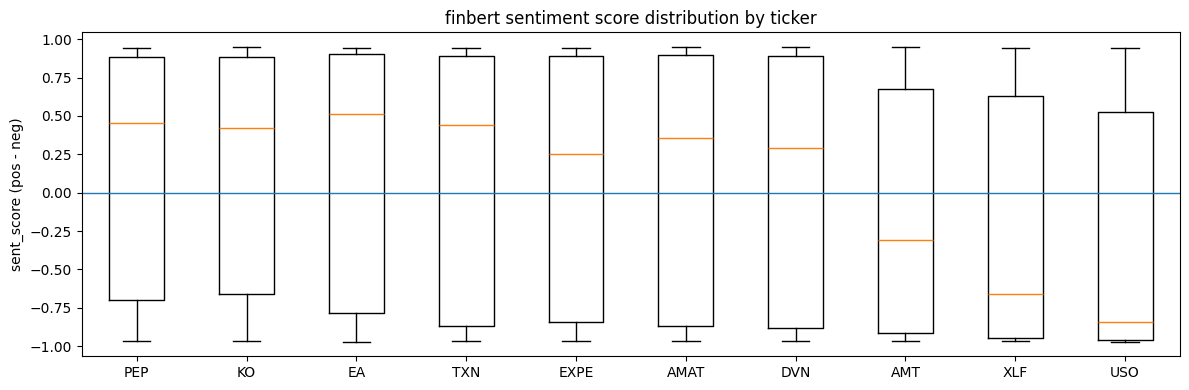

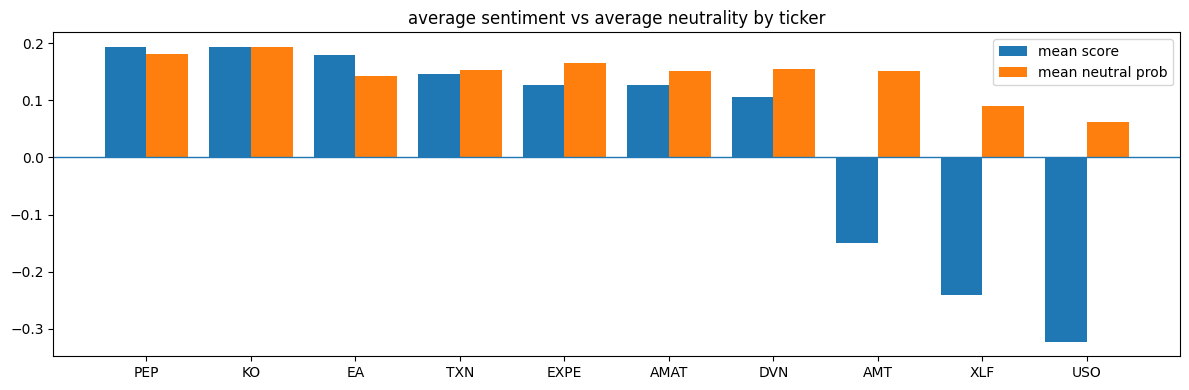

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# drop duplicate date columns to avoid pandas weirdness.
all_articles = all_articles.loc[:, ~all_articles.columns.duplicated()].copy()

# check probabilities sum close to one.
prob_sum = all_articles[["sent_pos", "sent_neg", "sent_neu"]].sum(axis=1)
print("prob_sum stats:\n", prob_sum.describe())
print("rows far from 1.0:", int((prob_sum - 1.0).abs().gt(1e-3).sum()))

# add a confidence feature (useful for weighting).
all_articles["sent_conf"] = 1.0 - all_articles["sent_neu"]

# summarize sentiment by ticker.
ticker_summary = (
    all_articles.groupby("ticker")
    .agg(
        n=("sent_score", "size"),
        mean_score=("sent_score", "mean"),
        median_score=("sent_score", "median"),
        mean_neu=("sent_neu", "mean"),
        mean_conf=("sent_conf", "mean"),
        frac_strong=("sent_score", lambda s: float((s.abs() >= 0.5).mean())),
        frac_pos=("sent_score", lambda s: float((s > 0.1).mean())),
        frac_neg=("sent_score", lambda s: float((s < -0.1).mean())),
    )
    .sort_values("mean_score", ascending=False)
)
display(ticker_summary)

# plot 1: boxplot of sentiment score per ticker.
tickers = ticker_summary.index.tolist()
data = [all_articles.loc[all_articles["ticker"] == t, "sent_score"].to_numpy() for t in tickers]

plt.figure(figsize=(12, 4))
plt.boxplot(data, labels=tickers, showfliers=False)
plt.axhline(0, linewidth=1)
plt.title("finbert sentiment score distribution by ticker")
plt.ylabel("sent_score (pos - neg)")
plt.tight_layout()
plt.show()

# plot 2: mean sentiment and mean neutrality per ticker.
plt.figure(figsize=(12, 4))
x = np.arange(len(tickers))
plt.bar(x - 0.2, ticker_summary["mean_score"].to_numpy(), width=0.4, label="mean score")
plt.bar(x + 0.2, ticker_summary["mean_neu"].to_numpy(),  width=0.4, label="mean neutral prob")
plt.axhline(0, linewidth=1)
plt.xticks(x, tickers)
plt.title("average sentiment vs average neutrality by ticker")
plt.tight_layout()
plt.legend()
plt.show()


In [13]:
import time

sample = all_articles["summary"].astype(str).head(200).tolist()

t0 = time.time()
_ = finbert_score(sample, batch_size=32, max_length=256)
t1 = time.time()

print("Seconds for 200 summaries:", round(t1 - t0, 3))
print("Summaries/sec:", round(200 / (t1 - t0), 3))

Seconds for 200 summaries: 2.897
Summaries/sec: 69.036


In [14]:
import pandas as pd

# print table shape and basic previews.
print("shape:", all_articles.shape)
display(all_articles.head(10))
display(all_articles.tail(10))
# list columns and data types.
print("\ncolumns:", list(all_articles.columns))
print("\ndtypes:\n", all_articles.dtypes)

# check if any column names repeat.
dupe_cols = all_articles.columns[all_articles.columns.duplicated()].tolist()
print("\nduplicate column names:", dupe_cols)

# drop repeated columns and keep first.
if dupe_cols:
    all_articles = all_articles.loc[:, ~all_articles.columns.duplicated()].copy()
    print("\nDropped duplicate columns. New columns:", list(all_articles.columns))

# convert date to day-level datetime.
all_articles["date"] = pd.to_datetime(all_articles["date"], errors="coerce").dt.floor("D")
print("\nDate range:", all_articles["date"].min(), "→", all_articles["date"].max())

# count missing values in key fields.
key_cols = ["date", "ticker", "summary", "sent_pos", "sent_neg", "sent_neu", "sent_score"]
missing = all_articles[key_cols].isna().sum().sort_values(ascending=False)
print("\nMissing values (key cols):")
display(missing)

# summarize per-ticker coverage and average length.
ticker_stats = (
    all_articles.groupby("ticker")
    .agg(
        articles=("summary", "count"),
        min_date=("date", "min"),
        max_date=("date", "max"),
        avg_len=("summary", lambda s: s.astype(str).str.len().mean())
    )
    .sort_values("articles", ascending=False)
)
display(ticker_stats)

# describe sentiment columns to sanity check.
display(all_articles[["sent_pos","sent_neg","sent_neu","sent_score"]].describe())

# count articles per ticker per day.
per_day = (
    all_articles.groupby(["ticker","date"])
    .size()
    .rename("articles_that_day")
    .reset_index()
    .sort_values("articles_that_day", ascending=False)
)
print("\nTop 20 (ticker, day) by number of articles:")
display(per_day.head(20))

# summarize daily article count distribution.
print("\nDistribution of articles per day (all tickers):")
display(per_day["articles_that_day"].describe())

# show one extreme day for inspection.
if len(per_day) > 0:
    ex = per_day.iloc[0]
    tkr, day = ex["ticker"], ex["date"]
    print(f"\nExample heavy-news day: ticker={tkr}, date={day.date()}, count={int(ex['articles_that_day'])}")
    display(
        all_articles[(all_articles["ticker"] == tkr) & (all_articles["date"] == day)]
        [["date","ticker","sent_score","summary"]]
        .head(10)
    )



shape: (20798, 8)


,date,ticker,summary,sent_pos,sent_neg,sent_neu,sent_score,sent_conf
0,2010-04-15,AMAT,"The article discusses the current ""tech renais...",0.189760,0.011210,0.799030,0.178549,0.200970
1,2010-04-27,AMAT,The article discusses a resurgence in telecom ...,0.957433,0.018482,0.024086,0.938951,0.975914
2,2010-04-30,AMAT,The article discusses the rise of Netflix and ...,0.942282,0.038269,0.019449,0.904012,0.980551
3,2010-05-19,AMAT,The Dow Jones Industrial Average fell 115 poin...,0.028542,0.951790,0.019668,-0.923249,0.980332
4,2010-05-20,AMAT,"Applied Materials, Inc. reported a second-quar...",0.007622,0.974809,0.017569,-0.967188,0.982431
5,2010-05-27,AMAT,The article discusses the recent market declin...,0.252260,0.711695,0.036046,-0.459435,0.963954
6,2010-06-04,AMAT,Applied Materials' stock has remained between ...,0.023324,0.954154,0.022523,-0.930830,0.977477
7,2010-07-01,AMAT,Shares of Applied Materials Inc. (AMAT) declin...,0.030757,0.941933,0.027310,-0.911176,0.972690
8,2010-07-13,AMAT,The article discusses significant movements in...,0.952928,0.021030,0.026042,0.931898,0.973958
9,2010-07-15,AMAT,The article discusses recent stock performance...,0.007382,0.974864,0.017754,-0.967482,0.982246


,date,ticker,summary,sent_pos,sent_neg,sent_neu,sent_score,sent_conf
20788,2023-11-30,XLF,Financial stocks were up before the market ope...,0.954845,0.027058,0.018096,0.927787,0.981904
20789,2023-12-01,XLF,"In November, the stock market experienced its ...",0.946895,0.017939,0.035166,0.928957,0.964834
20790,2023-12-04,XLF,The article discusses new options trading for ...,0.191646,0.029721,0.778633,0.161924,0.221367
20791,2023-12-05,XLF,"On Tuesday afternoon, the Financial sector was...",0.010715,0.972756,0.016529,-0.962040,0.983471
20792,2023-12-06,XLF,"Financial stocks were rising, with the XLF ETF...",0.957292,0.024153,0.018555,0.933139,0.981445
20793,2023-12-07,XLF,Financial stocks were slightly up in premarket...,0.183546,0.795277,0.021178,-0.611731,0.978822
20794,2023-12-08,XLF,Financial stocks showed mixed movements pre-ma...,0.070573,0.916078,0.013349,-0.845504,0.986651
20795,2023-12-11,XLF,Financial stocks were gaining before the marke...,0.721145,0.259765,0.019090,0.461380,0.980910
20796,2023-12-13,XLF,"Financial stocks edged higher premarket, with ...",0.955061,0.022332,0.022606,0.932729,0.977394
20797,2023-12-14,XLF,The article discusses newly traded options for...,0.120319,0.014833,0.864848,0.105485,0.135152



columns: ['date', 'ticker', 'summary', 'sent_pos', 'sent_neg', 'sent_neu', 'sent_score', 'sent_conf']

dtypes:
 date          datetime64[ns]
ticker                object
summary       string[python]
sent_pos             float32
sent_neg             float32
sent_neu             float32
sent_score           float32
sent_conf            float32
dtype: object

duplicate column names: []

Date range: 2009-06-06 00:00:00 → 2023-12-15 00:00:00

Missing values (key cols):


date          0
ticker        0
summary       0
sent_pos      0
sent_neg      0
sent_neu      0
sent_score    0
dtype: int64

,articles,min_date,max_date,avg_len
ticker,,,,
KO,3001,2009-10-14,2023-12-15,779.159280
USO,2774,2009-06-06,2023-12-15,671.232516
XLF,2409,2009-06-09,2023-12-14,719.109589
PEP,2347,2009-11-10,2023-12-15,777.008522
AMT,2002,2009-12-02,2023-12-15,711.692807
EA,1802,2011-12-22,2023-12-11,786.874584
TXN,1754,2009-12-09,2023-12-14,768.202965
AMAT,1653,2010-04-15,2023-12-14,767.335148
DVN,1615,2009-10-23,2023-12-14,774.786378


,sent_pos,sent_neg,sent_neu,sent_score
count,20798.000000,20798.000000,20798.000000,20798.000000
mean,0.438196,0.418919,0.142885,0.019277
std,0.392700,0.426634,0.234688,0.785737
min,0.006473,0.006274,0.008529,-0.969614
25%,0.028997,0.017617,0.020297,-0.911093
50%,0.325948,0.149507,0.034188,0.155943
75%,0.892006,0.942207,0.113667,0.860257
max,0.962923,0.976926,0.956235,0.949005



Top 20 (ticker, day) by number of articles:


,ticker,date,articles_that_day
0,AMAT,2010-04-15,1
13852,PEP,2023-12-05,1
13870,TXN,2010-04-28,1
13869,TXN,2010-04-27,1
13868,TXN,2010-04-26,1
13867,TXN,2010-04-23,1
13866,TXN,2010-04-17,1
13865,TXN,2010-03-30,1
13864,TXN,2010-03-08,1
13863,TXN,2010-02-23,1



Distribution of articles per day (all tickers):


count    20798.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: articles_that_day, dtype: float64


Example heavy-news day: ticker=AMAT, date=2010-04-15, count=1


,date,ticker,sent_score,summary
0,2010-04-15,AMAT,0.178549,"The article discusses the current ""tech renais..."


In [15]:
import numpy as np
import pandas as pd

# align article dates to trading days.
def add_aligned_date(all_articles: pd.DataFrame, trading_calendar: dict) -> pd.DataFrame:
    df = all_articles.copy()

    # coerce date to day-level datetime.
    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.floor("D")

    # create empty aligned date column.
    df["aligned_date"] = pd.NaT

    # align each ticker using its calendar.
    for t, g in df.groupby("ticker", sort=False):
        if t not in trading_calendar:
            continue

        # build sorted trading day array.
        trading_days = np.array(
            pd.to_datetime(trading_calendar[t]).sort_values().unique(),
            dtype="datetime64[ns]"
        )
        if len(trading_days) == 0:
            continue

        d = g["date"].values.astype("datetime64[ns]")
        idx = np.searchsorted(trading_days, d, side="left").astype(np.int64)
        can_map = idx < len(trading_days)

        mapped = np.full(len(idx), np.datetime64("NaT", "ns"), dtype="datetime64[ns]")
        mapped[can_map] = trading_days[idx[can_map]]

        df.loc[g.index, "aligned_date"] = pd.to_datetime(mapped)

    # drop rows that cannot be aligned.
    df = df.dropna(subset=["aligned_date"]).copy()

    # compute how far dates were shifted.
    df["shift_days"] = (df["aligned_date"] - df["date"]).dt.days.astype("int32")
    df["moved_forward"] = df["shift_days"] > 0
    return df

# build daily panel by merging prices and news.
def build_panel(prices_by_ticker: dict, articles_aligned: pd.DataFrame) -> pd.DataFrame:
    panels = []

    # aggregate in case multiple news map same day.
    daily_news = (
        articles_aligned.groupby(["ticker", "aligned_date"])
        .agg(
            news_count=("summary", "size"),
            sent_score_obs=("sent_score", "mean"),
            sent_conf_obs=("sent_conf", "mean"),
            sent_abs_obs=("sent_score", lambda s: float(np.mean(np.abs(s)))),
        )
        .reset_index()
    )

    # merge daily news onto each ticker prices.
    for t, p in prices_by_ticker.items():
        p = p.copy()
        p["date"] = pd.to_datetime(p["date"], errors="coerce").dt.floor("D")

        m = p.merge(
            daily_news[daily_news["ticker"] == t],
            left_on=["ticker", "date"],
            right_on=["ticker", "aligned_date"],
            how="left",
        )

        # define news presence on trading days.
        m["news_count"] = m["news_count"].fillna(0).astype("int32")
        m["has_news"] = (m["news_count"] > 0).astype("int8")

        # keep a clean sort order.
        m = m.sort_values(["ticker", "date"]).reset_index(drop=True)
        panels.append(m)

    return pd.concat(panels, ignore_index=True)

# compute days since last news event.
def add_days_since_news(panel: pd.DataFrame) -> pd.DataFrame:
    panel = panel.copy()

    # create event groups that increment on news.
    panel["event_group"] = panel.groupby("ticker")["has_news"].cumsum()

    # count days within each event group.
    panel["days_since_news"] = panel.groupby(["ticker", "event_group"]).cumcount().astype("float32")

    # set pre-first-news days to nan.
    pre_first = (panel["event_group"] == 0) & (panel["has_news"] == 0)
    panel.loc[pre_first, "days_since_news"] = np.nan

    return panel.drop(columns=["event_group"])

# apply exponential decay on no-news days.
def add_exponential_decay(panel: pd.DataFrame, lam: float = 0.03, baseline: float = 0.0) -> pd.DataFrame:
    panel = panel.copy()
    decay = float(np.exp(-lam))

    # compute per-ticker decayed sentiment feature.
    out = []
    for t, g in panel.groupby("ticker", sort=False):
        g = g.sort_values("date").copy()
        s_obs = g["sent_score_obs"].to_numpy(dtype=float)
        has = g["has_news"].to_numpy(dtype=bool)

        s_feat = np.empty(len(g), dtype=float)
        prev = baseline
        for i in range(len(g)):
            if has[i] and not np.isnan(s_obs[i]):
                prev = float(s_obs[i])
            else:
                prev = baseline + (prev - baseline) * decay
            s_feat[i] = prev

        g["sent_score_decay"] = s_feat.astype("float32")
        out.append(g)

    return pd.concat(out, ignore_index=True)

# build aligned articles with shift stats.
articles_aligned = add_aligned_date(all_articles, trading_calendar)

# report: shifted vs same-day, per ticker.
shift_report = (
    articles_aligned.groupby("ticker")
    .agg(
        n_articles=("summary", "size"),
        same_day=("moved_forward", lambda x: int((~x).sum())),
        moved_forward=("moved_forward", "sum"),
        mean_shift_days=("shift_days", "mean"),
        max_shift_days=("shift_days", "max"),
    )
    .reset_index()
    .sort_values("ticker")
)
display(shift_report)

# build full trading-day panel and add sparse-news features.
panel = build_panel(prices_by_ticker, articles_aligned)
panel = add_days_since_news(panel)
panel = add_exponential_decay(panel, lam=0.03, baseline=0.0)

# report: news coverage and gap sizes.
coverage_report = (
    panel.groupby("ticker")
    .agg(
        n_trading_days=("date", "size"),
        n_news_days=("has_news", "sum"),
        pct_news_days=("has_news", "mean"),
        max_days_since_news=("days_since_news", "max"),
    )
    .reset_index()
    .sort_values("pct_news_days")
)
display(coverage_report)

# quick peek at the final panel.
display(panel[["ticker","date","has_news","news_count","sent_score_obs","sent_score_decay","days_since_news"]].head(20))


,ticker,n_articles,same_day,moved_forward,mean_shift_days,max_shift_days
0,AMAT,1653,1509,144,0.128252,3
1,AMT,2002,1871,131,0.093906,3
2,DVN,1615,1391,224,0.211765,3
3,EA,1802,1611,191,0.162042,3
4,EXPE,1441,1353,88,0.097155,3
5,KO,3001,2532,469,0.243919,3
6,PEP,2347,2035,312,0.205369,3
7,TXN,1754,1599,155,0.132269,3
8,USO,2774,2636,138,0.066691,3
9,XLF,2409,2370,39,0.022416,3


,ticker,n_trading_days,n_news_days,pct_news_days,max_days_since_news
4,EXPE,3434,1390,0.404776,43.0
2,DVN,3561,1452,0.407751,39.0
0,AMAT,3443,1558,0.452512,40.0
7,TXN,3529,1655,0.468971,32.0
1,AMT,3534,1909,0.540181,119.0
3,EA,3015,1688,0.559867,12.0
6,PEP,3549,2107,0.593688,51.0
9,XLF,3657,2383,0.651627,47.0
5,KO,3568,2584,0.724215,36.0
8,USO,3658,2672,0.730454,72.0


,ticker,date,has_news,news_count,sent_score_obs,sent_score_decay,days_since_news
0,AMAT,2010-04-15,1,1,0.178549,0.178549,0.0
1,AMAT,2010-04-16,0,0,NaN,0.173273,1.0
2,AMAT,2010-04-19,0,0,NaN,0.168152,2.0
3,AMAT,2010-04-20,0,0,NaN,0.163182,3.0
4,AMAT,2010-04-21,0,0,NaN,0.158359,4.0
5,AMAT,2010-04-22,0,0,NaN,0.153679,5.0
6,AMAT,2010-04-23,0,0,NaN,0.149137,6.0
7,AMAT,2010-04-26,0,0,NaN,0.144729,7.0
8,AMAT,2010-04-27,1,1,0.938951,0.938951,0.0
9,AMAT,2010-04-28,0,0,NaN,0.911200,1.0


In [16]:
# where are the largest gaps?
gap_rows = (panel.dropna(subset=["days_since_news"])
            .sort_values("days_since_news", ascending=False)
            .loc[:, ["ticker","date","days_since_news","has_news","sent_score_decay"]]
            .head(30))
display(gap_rows)

# gap distribution per ticker
gap_stats = (panel.dropna(subset=["days_since_news"])
             .groupby("ticker")["days_since_news"]
             .agg(["count","mean","median","max"])
             .sort_values("max", ascending=False))
display(gap_stats)


,ticker,date,days_since_news,has_news,sent_score_decay
3754,AMT,2011-02-28,119.0,0,0.004904
3753,AMT,2011-02-25,118.0,0,0.005054
3752,AMT,2011-02-24,117.0,0,0.005208
3751,AMT,2011-02-23,116.0,0,0.005366
3750,AMT,2011-02-22,115.0,0,0.005530
3749,AMT,2011-02-18,114.0,0,0.005698
3748,AMT,2011-02-17,113.0,0,0.005872
3747,AMT,2011-02-16,112.0,0,0.006050
3746,AMT,2011-02-15,111.0,0,0.006235
3745,AMT,2011-02-14,110.0,0,0.006424


,count,mean,median,max
ticker,,,,
AMT,3534,5.809281,0.0,119.0
USO,3658,1.855932,0.0,72.0
PEP,3549,1.868977,0.0,51.0
XLF,3657,1.516817,0.0,47.0
EXPE,3434,2.788585,1.0,43.0
AMAT,3443,2.770258,1.0,40.0
DVN,3561,3.023027,1.0,39.0
KO,3568,1.117433,0.0,36.0
TXN,3529,2.168886,1.0,32.0


In [17]:
import pandas as pd

t = "AMT"
g = panel[panel["ticker"] == t].sort_values("date").reset_index(drop=True)

# find the row with the max gap
imax = g["days_since_news"].fillna(-1).idxmax()
row = g.loc[imax, ["date","days_since_news","sent_score_decay","has_news"]]
print("max gap row:\n", row)

# last news day before it
prev_news = g.loc[:imax][g.loc[:imax, "has_news"] == 1].tail(1)
# next news day after it
next_news = g.loc[imax:][g.loc[imax:, "has_news"] == 1].head(1)

print("\nprevious news day:")
display(prev_news[["date","has_news","news_count","sent_score_obs"]])

print("\nnext news day:")
display(next_news[["date","has_news","news_count","sent_score_obs"]])


max gap row:
 date                2011-02-28 00:00:00
days_since_news                   119.0
sent_score_decay               0.004904
has_news                              0
Name: 311, dtype: object

previous news day:


,date,has_news,news_count,sent_score_obs
192,2010-09-08,1,1,0.174184



next news day:


,date,has_news,news_count,sent_score_obs
312,2011-03-01,1,1,0.857151


In [18]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# compute rmse using a sqrt wrapper.
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# create next-day targets for modelling.
panel = panel.sort_values(["ticker", "date"]).reset_index(drop=True)
panel["log_adj_close"] = np.log(panel["adj_close"].astype(float))
panel["target_nextday_logret"] = panel.groupby("ticker")["log_adj_close"].diff(-1) * -1
panel["target_up"] = (panel["target_nextday_logret"] > 0).astype("int8")
panel = panel.dropna(subset=["target_nextday_logret"]).copy()

# define a volatility style target.
panel["target_abs_logret"] = panel["target_nextday_logret"].abs()

# create baseline price and volume features.
panel["ret1"] = panel.groupby("ticker")["adj_close"].pct_change()
panel["vol_z"] = panel.groupby("ticker")["volume"].transform(lambda s: (s - s.mean()) / (s.std() + 1e-9))

# do ticker-wise z score for sentiment.
g = panel.groupby("ticker")["sent_score_decay"]
panel["sent_decay_z"] = (panel["sent_score_decay"] - g.transform("mean")) / (g.transform("std") + 1e-9)

# build a rolling baseline and surprise signal.
panel["sent_z_roll20"] = panel.groupby("ticker")["sent_decay_z"].transform(
    lambda s: s.rolling(20, min_periods=5).mean()
)
panel["sent_surprise"] = panel["sent_decay_z"] - panel["sent_z_roll20"]

# add simple return lags for momentum context.
for L in [1, 2, 3, 5, 10]:
    panel[f"ret_lag{L}"] = panel.groupby("ticker")["ret1"].shift(L)

# add rolling mean and rolling std features.
panel["ret_roll5"] = panel.groupby("ticker")["ret1"].transform(lambda s: s.rolling(5, min_periods=5).mean())
panel["vol_roll5"] = panel.groupby("ticker")["ret1"].transform(lambda s: s.rolling(5, min_periods=5).std())

# optionally cap very long no-news gaps.
RESET_AFTER = 60
panel["sent_score_final"] = panel["sent_score_decay"].where(panel["days_since_news"] <= RESET_AFTER, 0.0)
panel["sent_final_z"] = panel.groupby("ticker")["sent_score_final"].transform(
    lambda s: (s - s.mean()) / (s.std() + 1e-9)
)

# drop rows created by lagging and rolling.
panel_ml = panel.dropna().copy()

# split by time to avoid leakage.
dates = panel_ml["date"].sort_values().unique()
cut1 = dates[int(0.70 * len(dates))]
cut2 = dates[int(0.85 * len(dates))]

train = panel_ml[panel_ml["date"] <= cut1].copy()
val   = panel_ml[(panel_ml["date"] > cut1) & (panel_ml["date"] <= cut2)].copy()
test  = panel_ml[panel_ml["date"] > cut2].copy()

print(
    "splits:",
    train["date"].min().date(), "→", train["date"].max().date(),
    "|", val["date"].min().date(), "→", val["date"].max().date(),
    "|", test["date"].min().date(), "→", test["date"].max().date(),
)

# compare feature sets for volatility prediction.
feature_sets = {
    "price_only": [
        "ret1", "vol_z", "ret_roll5", "vol_roll5",
        "ret_lag1", "ret_lag2", "ret_lag3", "ret_lag5", "ret_lag10",
    ],
    "plus_decay_raw": [
        "ret1", "vol_z", "ret_roll5", "vol_roll5",
        "ret_lag1", "ret_lag2", "ret_lag3", "ret_lag5", "ret_lag10",
        "sent_score_decay",
    ],
    "plus_decay_z": [
        "ret1", "vol_z", "ret_roll5", "vol_roll5",
        "ret_lag1", "ret_lag2", "ret_lag3", "ret_lag5", "ret_lag10",
        "sent_decay_z",
    ],
    "plus_surprise": [
        "ret1", "vol_z", "ret_roll5", "vol_roll5",
        "ret_lag1", "ret_lag2", "ret_lag3", "ret_lag5", "ret_lag10",
        "sent_decay_z", "sent_surprise",
    ],
    "plus_missingness": [
        "ret1", "vol_z", "ret_roll5", "vol_roll5",
        "ret_lag1", "ret_lag2", "ret_lag3", "ret_lag5", "ret_lag10",
        "sent_decay_z", "sent_surprise",
        "has_news", "news_count", "days_since_news",
    ],
    "plus_reset_rule": [
        "ret1", "vol_z", "ret_roll5", "vol_roll5",
        "ret_lag1", "ret_lag2", "ret_lag3", "ret_lag5", "ret_lag10",
        "sent_final_z", "sent_surprise",
        "has_news", "news_count", "days_since_news",
    ],
}

results = []
for name, feats in feature_sets.items():
    Xtr, ytr = train[feats], train["target_abs_logret"]
    Xva, yva = val[feats], val["target_abs_logret"]
    Xte, yte = test[feats], test["target_abs_logret"]

    # train a simple ridge regression baseline.
    reg = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=1.0, random_state=0)),
    ])
    reg.fit(Xtr, ytr)

    p_va = reg.predict(Xva)
    p_te = reg.predict(Xte)

    results.append({
        "features": name,
        "val_mae": mean_absolute_error(yva, p_va),
        "val_rmse": rmse(yva, p_va),
        "val_r2": r2_score(yva, p_va),
        "test_mae": mean_absolute_error(yte, p_te),
        "test_rmse": rmse(yte, p_te),
        "test_r2": r2_score(yte, p_te),
    })

results_df = pd.DataFrame(results).sort_values("test_rmse")
display(results_df)


splits: 2009-07-08 → 2019-11-01 | 2019-11-04 → 2021-11-22 | 2021-11-23 → 2023-12-14


,features,val_mae,val_rmse,val_r2,test_mae,test_rmse,test_r2
4,plus_missingness,0.010980,0.020807,0.217694,0.009286,0.014221,0.090590
5,plus_reset_rule,0.010980,0.020807,0.217694,0.009286,0.014221,0.090588
3,plus_surprise,0.010987,0.020807,0.217692,0.009294,0.014221,0.090534
0,price_only,0.010989,0.020809,0.217520,0.009294,0.014222,0.090501
2,plus_decay_z,0.010983,0.020805,0.217844,0.009291,0.014225,0.090057
1,plus_decay_raw,0.010970,0.020801,0.218110,0.009284,0.014229,0.089549


xgb test mae: 0.009518753399263157
xgb test rmse: 0.014422743978696029
xgb test r2: 0.06459669601590667
treeexplainer failed, using permutation explainer: ValueError("could not convert string to float: '[1.1364108E-2]'")


PermutationExplainer explainer: 501it [00:36, 11.07it/s]                         
/var/folders/03/nszg9d6n69sbgvj119fn16_00000gn/T/ipykernel_33281/998399497.py:64: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_exp.values, ex)


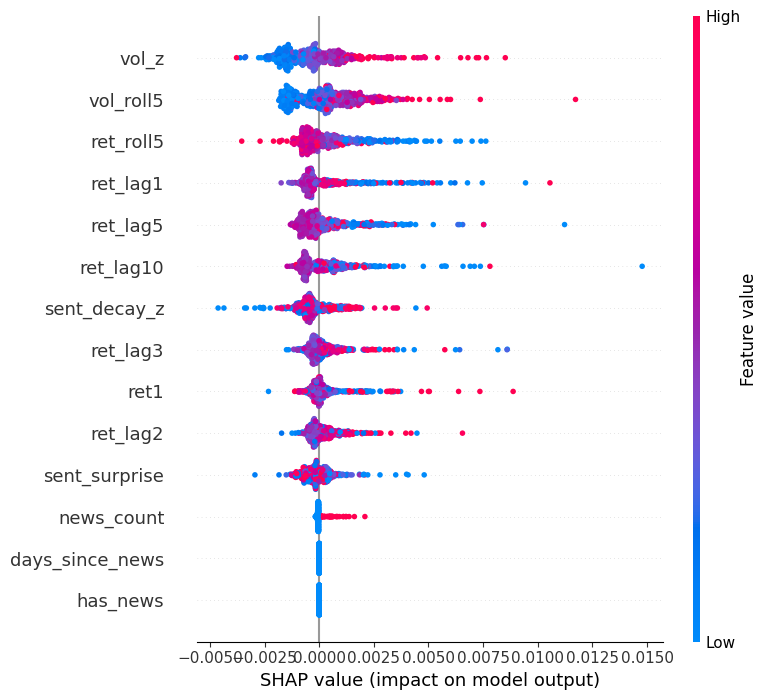

/var/folders/03/nszg9d6n69sbgvj119fn16_00000gn/T/ipykernel_33281/998399497.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_exp.values, ex, plot_type="bar")


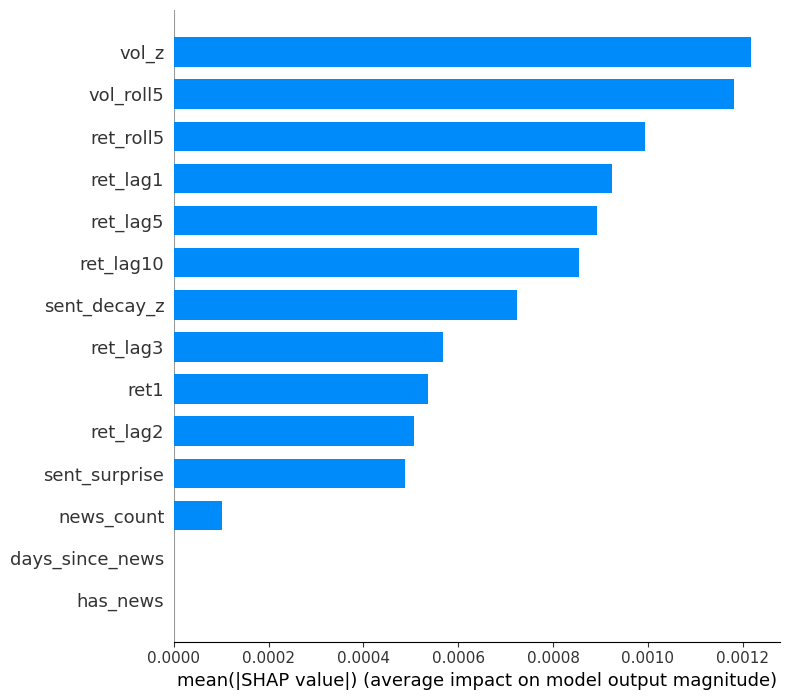

In [19]:
# step: xgboost training + metrics (unmodified core logic)

import os
import numpy as np
import shap
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# silence tokenizers fork parallelism warning.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# compute rmse using a sqrt wrapper.
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# pick the features you want to explain.
best_feats = feature_sets["plus_missingness"]
Xtr = train[best_feats]
ytr = train["target_abs_logret"].astype(float).to_numpy()
Xte = test[best_feats]
yte = test["target_abs_logret"].astype(float).to_numpy()

# set a scalar base score to avoid shap parsing issues.
base = float(np.mean(ytr))

# train xgboost regressor for volatility prediction.
xgb_model = xgb.XGBRegressor(
    n_estimators=800,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    base_score=base,
    random_state=0,
)
xgb_model.fit(Xtr, ytr)

# print test metrics for the fitted model.
pred = xgb_model.predict(Xte)
print("xgb test mae:", mean_absolute_error(yte, pred))
print("xgb test rmse:", rmse(yte, pred))
print("xgb test r2:", r2_score(yte, pred))

# step: xgboost shap explainability (unmodified)
# try tree explainer first and fall back safely.
try:
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(Xte)
    shap.summary_plot(shap_values, Xte)
    shap.summary_plot(shap_values, Xte, plot_type="bar")
except Exception as e:
    print("treeexplainer failed, using permutation explainer:", repr(e))

    # use small background for speed and stability.
    bg = Xtr.sample(n=min(200, len(Xtr)), random_state=0)
    ex = Xte.sample(n=min(500, len(Xte)), random_state=0)

    # explain predictions with a model-agnostic method.
    explainer = shap.Explainer(xgb_model.predict, bg, algorithm="permutation")
    shap_exp = explainer(ex)

    shap.summary_plot(shap_exp.values, ex)
    shap.summary_plot(shap_exp.values, ex, plot_type="bar")


In [20]:
# step: lstm + transformer imports and reproducibility

import math
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# reuse rmse name (overwrites previous definition, which is fine)
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# step: sequence building helpers (panel -> (n, t, f))

def _infer_time_col(df):
    if "date" in df.columns:
        return "date"
    if hasattr(df.index, "dtype") and "datetime" in str(df.index.dtype).lower():
        return None  # use index
    return None

def _ensure_sort(df, time_col):
    if time_col is None:
        return df.sort_index()
    return df.sort_values(time_col)

def _ensure_group_col(df):
    if "ticker" in df.columns:
        return "ticker"
    tmp = df.copy()
    tmp["ticker"] = "ALL"
    return "ticker", tmp

def make_sequences(df, feature_cols, target_col, seq_len=20):
    time_col = _infer_time_col(df)
    group_col, df2 = _ensure_group_col(df) if "ticker" not in df.columns else ("ticker", df)

    X_list, y_list = [], []
    for _, g in df2.groupby(group_col):
        g = _ensure_sort(g, time_col)
        X = g[feature_cols].to_numpy(dtype=np.float32)
        y = g[target_col].to_numpy(dtype=np.float32)

        if len(g) < seq_len:
            continue

        for i in range(seq_len - 1, len(g)):
            X_list.append(X[i - seq_len + 1 : i + 1])
            y_list.append(y[i])

    if not X_list:
        raise ValueError("No sequences were created. Check seq_len and per-ticker data length.")

    return np.stack(X_list, axis=0), np.array(y_list, dtype=np.float32)

def split_val_from_train(train_df, val_frac=0.1):
    time_col = _infer_time_col(train_df)
    group_col, df2 = _ensure_group_col(train_df) if "ticker" not in train_df.columns else ("ticker", train_df)

    train_parts, val_parts = [], []
    for _, g in df2.groupby(group_col):
        g = _ensure_sort(g, time_col)
        n = len(g)
        k = max(1, int(round(n * val_frac)))
        val_parts.append(g.iloc[-k:])
        train_parts.append(g.iloc[:-k] if n > k else g.iloc[:0])

    tr = pd.concat(train_parts, axis=0)
    va = pd.concat(val_parts, axis=0)
    return tr, va


# step: torch dataset and models (lstm + transformer)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, T, F)
        self.y = torch.from_numpy(y).unsqueeze(-1)  # (N, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div)
        pe[:, 1::2] = torch.cos(position * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TransformerRegressor(nn.Module):
    def __init__(self, n_features, d_model=128, nhead=4, num_layers=2, dim_ff=256, dropout=0.1, max_len=512):
        super().__init__()
        self.inp = nn.Linear(n_features, d_model)
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
        )

    def forward(self, x):
        z = self.inp(x)
        z = self.pos(z)
        z = self.enc(z)
        last = z[:, -1, :]
        return self.head(last)


# step: training and prediction loops

@torch.no_grad()
def predict_torch(model, loader, device):
    model.eval()
    ys, preds = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yhat = model(xb).detach().cpu().numpy().reshape(-1)
        preds.append(yhat)
        ys.append(yb.numpy().reshape(-1))
    return np.concatenate(ys), np.concatenate(preds)

def train_model(model, train_loader, val_loader, device, epochs=30, lr=1e-3, weight_decay=1e-4, patience=5):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_state = None
    best_val = float("inf")
    bad = 0

    for _ep in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad(set_to_none=True)
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()

        yv, pv = predict_torch(model, val_loader, device)
        val_rmse = rmse(yv, pv)

        if val_rmse < best_val - 1e-6:
            best_val = val_rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


# step: build sequences, scale features, and create dataloaders

SEQ_LEN = 20
BATCH = 512
EPOCHS = 30
target_col = "target_abs_logret"

if "val" in globals():
    val_df = val
    train_df = train
else:
    train_df, val_df = split_val_from_train(train, val_frac=0.1)

Xtr_seq, ytr_seq = make_sequences(train_df, best_feats, target_col, seq_len=SEQ_LEN)
Xva_seq, yva_seq = make_sequences(val_df,   best_feats, target_col, seq_len=SEQ_LEN)
Xte_seq, yte_seq = make_sequences(test,     best_feats, target_col, seq_len=SEQ_LEN)

scaler = StandardScaler()
Ntr, T, F = Xtr_seq.shape
scaler.fit(Xtr_seq.reshape(Ntr * T, F))

def apply_scaler(X):
    N, T, F = X.shape
    return scaler.transform(X.reshape(N * T, F)).reshape(N, T, F).astype(np.float32)

Xtr_seq = apply_scaler(Xtr_seq)
Xva_seq = apply_scaler(Xva_seq)
Xte_seq = apply_scaler(Xte_seq)

train_loader = DataLoader(SeqDataset(Xtr_seq, ytr_seq), batch_size=BATCH, shuffle=True, drop_last=False)
val_loader   = DataLoader(SeqDataset(Xva_seq, yva_seq), batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(SeqDataset(Xte_seq, yte_seq), batch_size=BATCH, shuffle=False, drop_last=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# step: train and evaluate lstm model

lstm = LSTMRegressor(n_features=F, hidden=128, layers=2, dropout=0.2)
lstm = train_model(lstm, train_loader, val_loader, device, epochs=EPOCHS, lr=1e-3, weight_decay=1e-4, patience=5)
y_true_lstm, y_pred_lstm = predict_torch(lstm, test_loader, device)
print("\nLSTM test mae:", mean_absolute_error(y_true_lstm, y_pred_lstm))
print("LSTM test rmse:", rmse(y_true_lstm, y_pred_lstm))
print("LSTM test r2:", r2_score(y_true_lstm, y_pred_lstm))


# step: train and evaluate transformer model

trf = TransformerRegressor(n_features=F, d_model=128, nhead=4, num_layers=2, dim_ff=256, dropout=0.1, max_len=512)
trf = train_model(trf, train_loader, val_loader, device, epochs=EPOCHS, lr=7e-4, weight_decay=1e-4, patience=5)
y_true_trf, y_pred_trf = predict_torch(trf, test_loader, device)
print("\nTransformer test mae:", mean_absolute_error(y_true_trf, y_pred_trf))
print("Transformer test rmse:", rmse(y_true_trf, y_pred_trf))
print("Transformer test r2:", r2_score(y_true_trf, y_pred_trf))


# step: permutation importance for sequence models (lstm + transformer)

def perm_importance_sequence(
    model,
    X_seq,           # (N, T, F) scaled
    y_true,          # (N,)
    feature_names,   # list of len F
    device,
    batch_size=1024,
    n_repeats=3,
    shuffle_over_time=True,
    seed=0,
):
    """
    Returns a list of (feature, mean_delta_rmse, std_delta_rmse) sorted desc.
    """
    rng = np.random.default_rng(seed)

    base_loader = DataLoader(SeqDataset(X_seq, y_true.astype(np.float32)), batch_size=batch_size, shuffle=False)
    yt, yp = predict_torch(model, base_loader, device)
    base_rmse = rmse(yt, yp)

    deltas = np.zeros((len(feature_names), n_repeats), dtype=np.float64)

    for j in range(len(feature_names)):
        for r in range(n_repeats):
            Xp = X_seq.copy()

            if shuffle_over_time:
                flat = Xp[:, :, j].reshape(-1)
                perm = rng.permutation(flat.shape[0])
                Xp[:, :, j] = flat[perm].reshape(Xp.shape[0], Xp.shape[1])
            else:
                perm = rng.permutation(Xp.shape[0])
                Xp[:, :, j] = Xp[perm, :, j]

            loader = DataLoader(SeqDataset(Xp, y_true.astype(np.float32)), batch_size=batch_size, shuffle=False)
            yt2, yp2 = predict_torch(model, loader, device)
            deltas[j, r] = rmse(yt2, yp2) - base_rmse

    rows = []
    for j, name in enumerate(feature_names):
        rows.append((name, float(deltas[j].mean()), float(deltas[j].std(ddof=1) if n_repeats > 1 else 0.0)))

    rows.sort(key=lambda x: x[1], reverse=True)
    return base_rmse, rows

# compute and print permutation importance for lstm
lstm_base_rmse, lstm_pi = perm_importance_sequence(
    model=lstm,
    X_seq=Xte_seq,
    y_true=yte_seq,
    feature_names=list(best_feats),
    device=device,
    batch_size=1024,
    n_repeats=3,
    shuffle_over_time=True,
    seed=0,
)
print("\nLSTM permutation importance (delta RMSE vs baseline RMSE={:.6f})".format(lstm_base_rmse))
for feat, mean_d, std_d in lstm_pi[:20]:
    print(f"  {feat:>30s}  +{mean_d:.6f}  (std {std_d:.6f})")

# compute and print permutation importance for transformer
trf_base_rmse, trf_pi = perm_importance_sequence(
    model=trf,
    X_seq=Xte_seq,
    y_true=yte_seq,
    feature_names=list(best_feats),
    device=device,
    batch_size=1024,
    n_repeats=3,
    shuffle_over_time=True,
    seed=1,
)
print("\nTransformer permutation importance (delta RMSE vs baseline RMSE={:.6f})".format(trf_base_rmse))
for feat, mean_d, std_d in trf_pi[:20]:
    print(f"  {feat:>30s}  +{mean_d:.6f}  (std {std_d:.6f})")



LSTM test mae: 0.009561396203935146
LSTM test rmse: 0.013824730779986964
LSTM test r2: 0.12408280372619629


/Users/rohanbadami/Downloads/TIME-IMM/FNSPID/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



Transformer test mae: 0.010132216848433018
Transformer test rmse: 0.01396839840204333
Transformer test r2: 0.10578304529190063

LSTM permutation importance (delta RMSE vs baseline RMSE=0.013825)
                       vol_roll5  +0.001003  (std 0.000049)
                       ret_roll5  +0.000252  (std 0.000013)
                        ret_lag2  +0.000166  (std 0.000013)
                        ret_lag1  +0.000056  (std 0.000023)
                           vol_z  +0.000031  (std 0.000010)
                            ret1  +0.000028  (std 0.000020)
                   sent_surprise  +0.000017  (std 0.000003)
                       ret_lag10  +0.000011  (std 0.000012)
                        has_news  +0.000000  (std 0.000000)
                 days_since_news  +0.000000  (std 0.000000)
                    sent_decay_z  +-0.000002  (std 0.000012)
                        ret_lag5  +-0.000014  (std 0.000012)
                      news_count  +-0.000015  (std 0.000012)
                     

In [21]:
import numpy as np
import pandas as pd

use_perm = "shap_exp" in globals()
X_show = ex.copy() if use_perm else Xte.copy()
sv = shap_exp.values if use_perm else shap_values

j = list(X_show.columns).index("sent_surprise")

df = X_show.copy()
df["shap_sent"] = sv[:, j]
df["vol_bucket"] = pd.qcut(df["vol_z"], q=3, labels=["low_volz","mid_volz","high_volz"])
df["sent_bin"] = pd.qcut(df["sent_surprise"], q=8, duplicates="drop")

out = (df.groupby(["vol_bucket","sent_bin"], observed=True)["shap_sent"]
         .mean()
         .reset_index())

display(out)




,vol_bucket,sent_bin,shap_sent
0,low_volz,"(-2.279, -1.32]",0.000365
1,low_volz,"(-1.32, -0.934]",-0.000358
2,low_volz,"(-0.934, -0.417]",0.000279
3,low_volz,"(-0.417, 0.137]",0.000433
4,low_volz,"(0.137, 0.443]",-0.000361
5,low_volz,"(0.443, 0.714]",-0.000437
6,low_volz,"(0.714, 1.04]",-0.000304
7,low_volz,"(1.04, 2.2]",-0.000135
8,mid_volz,"(-2.279, -1.32]",0.000422
9,mid_volz,"(-1.32, -0.934]",-0.000011


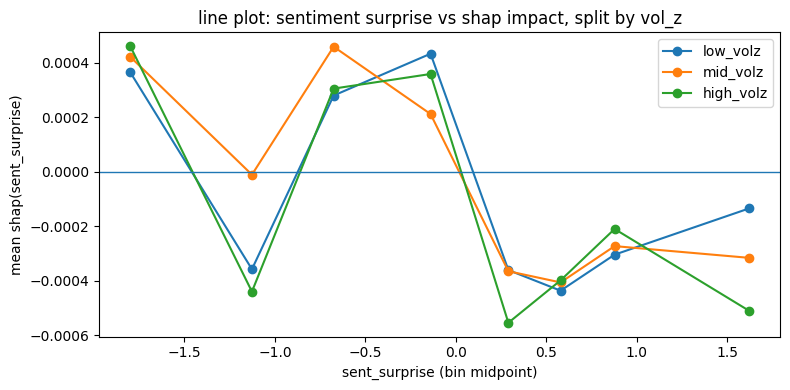

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_plot = out.copy()

# convert interval bins into numeric midpoints for plotting.
df_plot["sent_mid"] = df_plot["sent_bin"].apply(lambda iv: float(iv.mid))

# map vol buckets to a stable order.
order = ["low_volz", "mid_volz", "high_volz"]
df_plot["vol_bucket"] = pd.Categorical(df_plot["vol_bucket"], categories=order, ordered=True)
df_plot = df_plot.sort_values(["vol_bucket", "sent_mid"])

plt.figure(figsize=(8, 4))
for vb in order:
    sub = df_plot[df_plot["vol_bucket"] == vb]
    plt.plot(sub["sent_mid"], sub["shap_sent"], marker="o", label=vb)

plt.axhline(0, linewidth=1)
plt.title("line plot: sentiment surprise vs shap impact, split by vol_z")
plt.xlabel("sent_surprise (bin midpoint)")
plt.ylabel("mean shap(sent_surprise)")
plt.tight_layout()
plt.legend()
plt.show()



In [23]:
import numpy as np

slopes = []
for vb in ["low_volz", "mid_volz", "high_volz"]:
    sub = df_plot[df_plot["vol_bucket"] == vb]
    x = sub["sent_mid"].to_numpy()
    y = sub["shap_sent"].to_numpy()
    m = float(np.polyfit(x, y, 1)[0])
    slopes.append({"vol_bucket": vb, "slope_shap_per_sent": m})

slopes_df = pd.DataFrame(slopes)
display(slopes_df)


,vol_bucket,slope_shap_per_sent
0,low_volz,-0.000156
1,mid_volz,-0.000250
2,high_volz,-0.000232


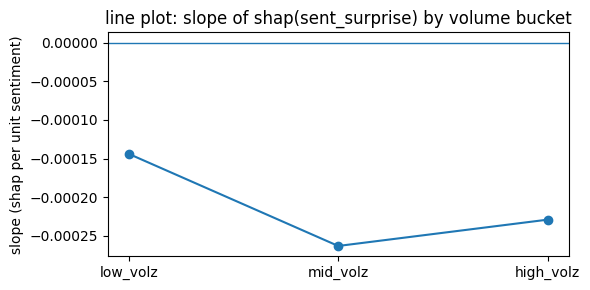

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

slopes_df = pd.DataFrame({
    "vol_bucket": ["low_volz","mid_volz","high_volz"],
    "slope_shap_per_sent": [-0.000144, -0.000263, -0.000229]
})

plt.figure(figsize=(6,3))
plt.plot(slopes_df["vol_bucket"], slopes_df["slope_shap_per_sent"], marker="o")
plt.axhline(0, linewidth=1)
plt.title("line plot: slope of shap(sent_surprise) by volume bucket")
plt.ylabel("slope (shap per unit sentiment)")
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# compute rmse with sqrt of mse.
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# fit xgb and return metrics.
def fit_eval_xgb(Xtr, ytr, Xte, yte, seed=0):
    base = float(np.mean(ytr))
    model = xgb.XGBRegressor(
        n_estimators=800,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        base_score=base,
        random_state=seed,
    )
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    return {
        "mae": mean_absolute_error(yte, pred),
        "rmse": rmse(yte, pred),
        "r2": r2_score(yte, pred),
    }

# pick your best feature set.
best_feats = feature_sets["plus_missingness"]

Xtr = train[best_feats].copy()
ytr = train["target_abs_logret"].astype(float).to_numpy()
Xte = test[best_feats].copy()
yte = test["target_abs_logret"].astype(float).to_numpy()

# real model performance.
real_metrics = fit_eval_xgb(Xtr, ytr, Xte, yte, seed=0)
print("real:", real_metrics)

# build placebo by shuffling sentiment features within each ticker.
sent_cols = [c for c in best_feats if "sent" in c]
print("shuffling sentiment cols:", sent_cols)

train_pl = train.copy()
test_pl = test.copy()

rng = np.random.default_rng(0)
for c in sent_cols:
    train_pl[c] = train_pl.groupby("ticker")[c].transform(lambda s: rng.permutation(s.to_numpy()))
    test_pl[c] = test_pl.groupby("ticker")[c].transform(lambda s: rng.permutation(s.to_numpy()))

Xtr_pl = train_pl[best_feats].copy()
Xte_pl = test_pl[best_feats].copy()

placebo_metrics = fit_eval_xgb(Xtr_pl, ytr, Xte_pl, yte, seed=0)
print("placebo:", placebo_metrics)

# run multiple placebo shuffles to get a small null distribution.
placebo_runs = []
for k in range(30):
    rng = np.random.default_rng(100 + k)
    trp = train.copy()
    tep = test.copy()
    for c in sent_cols:
        trp[c] = trp.groupby("ticker")[c].transform(lambda s: rng.permutation(s.to_numpy()))
        tep[c] = tep.groupby("ticker")[c].transform(lambda s: rng.permutation(s.to_numpy()))

    m = fit_eval_xgb(trp[best_feats], ytr, tep[best_feats], yte, seed=100 + k)
    m["run"] = k
    placebo_runs.append(m)

placebo_df = pd.DataFrame(placebo_runs)
display(placebo_df.describe())

# compare real to placebo in a simple table.
summary = pd.DataFrame([
    {"setting": "real", **real_metrics},
    {"setting": "placebo_mean", "mae": placebo_df["mae"].mean(), "rmse": placebo_df["rmse"].mean(), "r2": placebo_df["r2"].mean()},
    {"setting": "placebo_std", "mae": placebo_df["mae"].std(), "rmse": placebo_df["rmse"].std(), "r2": placebo_df["r2"].std()},
])
display(summary)


real: {'mae': 0.009518753399263157, 'rmse': 0.014422743978696029, 'r2': 0.06459669601590667}
shuffling sentiment cols: ['sent_decay_z', 'sent_surprise']
placebo: {'mae': 0.009499040809898983, 'rmse': 0.014298445153596559, 'r2': 0.08065030022008679}


,mae,rmse,r2,run
count,30.000000,30.000000,30.000000,30.000000
mean,0.009497,0.014372,0.071136,14.500000
std,0.000036,0.000052,0.006768,8.803408
min,0.009411,0.014285,0.056223,0.000000
25%,0.009477,0.014339,0.067622,7.250000
50%,0.009498,0.014374,0.070894,14.500000
75%,0.009529,0.014399,0.075490,21.750000
max,0.009556,0.014487,0.082410,29.000000


,setting,mae,rmse,r2
0,real,0.009519,0.014423,0.064597
1,placebo_mean,0.009497,0.014372,0.071136
2,placebo_std,0.000036,0.000052,0.006768


In [26]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# compute rmse with sqrt of mse.
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# rolling window evaluation across time.
def rolling_eval(panel_ml: pd.DataFrame, feats, target_col="target_abs_logret",
                 train_years=8, test_months=6, min_train_rows=2000, seed=0):

    df = panel_ml.sort_values("date").copy()
    df["date"] = pd.to_datetime(df["date"]).dt.floor("D")

    start = df["date"].min()
    end = df["date"].max()

    # start after we have enough training history.
    cursor = start + pd.DateOffset(years=train_years)
    rows = []

    while cursor + pd.DateOffset(months=test_months) <= end:
        train_end = cursor
        test_end = cursor + pd.DateOffset(months=test_months)

        tr = df[df["date"] < train_end].copy()
        te = df[(df["date"] >= train_end) & (df["date"] < test_end)].copy()

        if len(tr) < min_train_rows or len(te) < 500:
            cursor = cursor + pd.DateOffset(months=test_months)
            continue

        Xtr = tr[feats]
        ytr = tr[target_col].astype(float).to_numpy()
        Xte = te[feats]
        yte = te[target_col].astype(float).to_numpy()

        base = float(np.mean(ytr))
        model = xgb.XGBRegressor(
            n_estimators=800,
            max_depth=4,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            base_score=base,
            random_state=seed,
        )
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)

        rows.append({
            "train_end": train_end.date(),
            "test_end": test_end.date(),
            "train_rows": len(tr),
            "test_rows": len(te),
            "mae": mean_absolute_error(yte, pred),
            "rmse": rmse(yte, pred),
            "r2": r2_score(yte, pred),
        })

        cursor = cursor + pd.DateOffset(months=test_months)

    return pd.DataFrame(rows)

# run rolling evaluation for two competing feature sets.
feats_price = feature_sets["price_only"]
feats_full = feature_sets["plus_missingness"]

roll_price = rolling_eval(panel_ml, feats_price, seed=0)
roll_full = rolling_eval(panel_ml, feats_full, seed=0)

roll_price["model"] = "price_only"
roll_full["model"] = "plus_missingness"
roll = pd.concat([roll_price, roll_full], ignore_index=True)

display(roll.head(10))
display(roll.groupby("model")[["mae","rmse","r2"]].agg(["mean","median","std"]))

# compute per-window deltas (full minus price).
merged = roll_price.merge(roll_full, on=["train_end","test_end"], suffixes=("_price","_full"))
merged["rmse_delta_full_minus_price"] = merged["rmse_full"] - merged["rmse_price"]
merged["mae_delta_full_minus_price"] = merged["mae_full"] - merged["mae_price"]
merged["r2_delta_full_minus_price"] = merged["r2_full"] - merged["r2_price"]

display(merged[["train_end","test_end","rmse_price","rmse_full","rmse_delta_full_minus_price",
                "mae_price","mae_full","mae_delta_full_minus_price",
                "r2_price","r2_full","r2_delta_full_minus_price"]].head(12))

print("delta rmse mean:", merged["rmse_delta_full_minus_price"].mean())
print("delta rmse median:", merged["rmse_delta_full_minus_price"].median())


,train_end,test_end,train_rows,test_rows,mae,rmse,r2,model
0,2017-07-08,2018-01-08,8262,987,0.006711,0.010496,0.011587,price_only
1,2018-01-08,2018-07-08,9249,949,0.008484,0.013251,0.030118,price_only
2,2018-07-08,2019-01-08,10198,859,0.008645,0.012325,0.079377,price_only
3,2019-01-08,2019-07-08,11057,720,0.008062,0.012784,0.105990,price_only
4,2019-07-08,2020-01-08,11777,584,0.008168,0.017512,0.022733,price_only
5,2020-01-08,2020-07-08,12361,700,0.019261,0.035143,0.166026,price_only
6,2020-07-08,2021-01-08,13061,683,0.008806,0.012323,0.137575,price_only
7,2021-01-08,2021-07-08,13744,845,0.008608,0.012474,0.190025,price_only
8,2021-07-08,2022-01-08,14589,865,0.008653,0.013285,0.118832,price_only
9,2022-01-08,2022-07-08,15454,992,0.011574,0.017358,0.029652,price_only


mae                          rmse                      \
                      mean    median       std      mean    median       std   
model                                                                          
plus_missingness  0.009555  0.008594  0.003244  0.015207  0.012902  0.006668   
price_only        0.009603  0.008626  0.003269  0.015227  0.013017  0.006622   

                        r2                      
                      mean    median       std  
model                                           
plus_missingness  0.087342  0.072181  0.057908  
price_only        0.083400  0.080039  0.060703

,train_end,test_end,rmse_price,rmse_full,rmse_delta_full_minus_price,mae_price,mae_full,mae_delta_full_minus_price,r2_price,r2_full,r2_delta_full_minus_price
0,2017-07-08,2018-01-08,0.010496,0.010414,-0.000081,0.006711,0.006713,0.000002,0.011587,0.026830,0.015243
1,2018-01-08,2018-07-08,0.013251,0.013179,-0.000072,0.008484,0.008437,-0.000047,0.030118,0.040636,0.010519
2,2018-07-08,2019-01-08,0.012325,0.012438,0.000113,0.008645,0.008605,-0.000039,0.079377,0.062439,-0.016938
3,2019-01-08,2019-07-08,0.012784,0.012625,-0.000159,0.008062,0.007966,-0.000096,0.105990,0.128129,0.022140
4,2019-07-08,2020-01-08,0.017512,0.017457,-0.000055,0.008168,0.008064,-0.000105,0.022733,0.028899,0.006167
5,2020-01-08,2020-07-08,0.035143,0.035285,0.000142,0.019261,0.019126,-0.000135,0.166026,0.159285,-0.006741
6,2020-07-08,2021-01-08,0.012323,0.012341,0.000018,0.008806,0.008817,0.000011,0.137575,0.135040,-0.002535
7,2021-01-08,2021-07-08,0.012474,0.012483,0.000009,0.008608,0.008591,-0.000017,0.190025,0.188884,-0.001140
8,2021-07-08,2022-01-08,0.013285,0.013207,-0.000078,0.008653,0.008597,-0.000056,0.118832,0.129126,0.010294
9,2022-01-08,2022-07-08,0.017358,0.017324,-0.000034,0.011574,0.011555,-0.000019,0.029652,0.033413,0.003761


delta rmse mean: -2.040741892696653e-05
delta rmse median: -3.653462770898848e-05
